## The Art of Strategy by Avinash Dixit and Barry Nalebuff

Guess the number that I picked, an integer between 1 and 100. After each of your guesses, I’ll tell you if the number you guessed is higher or lower than the number I picked. Game would start with \\$100 prize money and reduce \\$20 for each wrong guess. So \\$100 for first guess, \\$80 for second, etc etc.

Given a distribution for the number, I can solve for the optimal strategy using recursion. The probability of winning is a function of the number of guesses remaining in the interval and the interval.
Value of the whole game is $V(5, 1, 100)$

$$
V(n, i, j) = \max_k \left( \text{pdf}(k) \cdot \max(0, 20 \cdot n) 
+ \text{cdf}(i, k-1) \cdot V(n-1, i, k-1) 
+ \text{cdf}(k+1, j) \cdot V(n-1, k+1, j) \right)
$$

$$V(0, i, j) = 0$$

In [1]:
import pandas as pd
import jax
import jax.numpy as jnp

In [2]:
nguesses = 5
N = 10

In [3]:
@jax.jit
def optimal_guess(pdf):
    V = jnp.zeros((nguesses + 1, N, N))
    
    # Pre-compute cumulative sums
    cumsum = jnp.cumsum(pdf)
    
    def get_range_sum(i, j):
        return cumsum[j] - jnp.where(i > 0, cumsum[i-1], 0)
    
    def compute_value(n, i, j, k):
        direct_reward = pdf[k] * n * 20
        left_mask = k > i 
        right_mask = k < j
        
        left_sum = get_range_sum(i, k-1)
        right_sum = get_range_sum(k+1, j)
        
        left_contribution = jnp.where(left_mask, left_sum * V[n-1, i, k-1], 0)
        right_contribution = jnp.where(right_mask, right_sum * V[n-1, k+1, j], 0)
        
        return direct_reward + left_contribution + right_contribution
    
    for n in range(1, nguesses + 1):
        for i in range(N):
            for j in range(i, N):
                k_range = jnp.arange(i, j + 1)
                values = jax.vmap(lambda k: compute_value(n, i, j, k))(k_range)
                V = V.at[n,i,j].set(jnp.max(values))
    
    return V

In [4]:
pdf = jnp.ones(N) / N

In [5]:
%%time
V = optimal_guess(pdf)
V[nguesses, 0, N - 1]

CPU times: user 5.16 s, sys: 143 ms, total: 5.3 s
Wall time: 4.13 s


Array(24.140804, dtype=float32)

In [6]:
# Get gradient of V[nguesses, 0, N-1] with respect to pdf
# Use log-transform to ensure positivity and softmax to ensure sum to 1
def transform_params(x):
    return jax.nn.softmax(x)

# Initialize parameters in log space
init_params = jnp.log(pdf + 1e-8)  # Add small constant for numerical stability

@jax.jit
def objective(params):
    transformed_pdf = transform_params(params)
    V = optimal_guess(transformed_pdf)
    return V[nguesses, 0, N - 1]

In [7]:
# Use built-in Adam optimizer from optax
import optax

# Initialize optimizer
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(init_params)

# Training loop parameters
num_steps = 100
improvement_threshold = 1e-6
patience = 5
window_size = 10

best_value = float('inf')
best_params = init_params
recent_values = []
no_improvement_count = 0

params = init_params
step = 0

while True:
    # Compute gradient and update parameters
    gradient = jax.grad(objective)(params)
    updates, opt_state = optimizer.update(gradient, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Evaluate current solution
    value = objective(params)
    
    # Keep track of best solution
    if value < best_value:
        best_value = value
        best_params = params
    
    if step % 10 == 0:
        print(f"Step {step}, Value: {value}")
        recent_values.append(value)
        
        if len(recent_values) > window_size:
            # Check if there's been significant improvement in the last window
            improvement = recent_values[-window_size] - recent_values[-1]
            if improvement < improvement_threshold:
                no_improvement_count += 1
            else:
                no_improvement_count = 0
            
            if no_improvement_count >= patience:
                print(f"\nStopping early at step {step} due to no significant improvement")
                break
            
            recent_values.pop(0)  # Remove oldest value
    
    step += 1
# Get final optimized PDF
final_pdf = transform_params(best_params)
print("\nFinal objective value:", best_value)
print("Optimized PDF:", final_pdf)

Step 0, Value: 24.11521339416504
Step 10, Value: 23.472721099853516
Step 20, Value: 23.158540725708008
Step 30, Value: 22.967437744140625
Step 40, Value: 22.78668785095215
Step 50, Value: 22.77311897277832
Step 60, Value: 22.742786407470703
Step 70, Value: 22.72612953186035
Step 80, Value: 22.75032615661621
Step 90, Value: 22.747798919677734
Step 100, Value: 22.749523162841797
Step 110, Value: 22.75847053527832
Step 120, Value: 22.760089874267578
Step 130, Value: 22.746824264526367
Step 140, Value: 22.735126495361328
Step 150, Value: 22.73162841796875
Step 160, Value: 22.746870040893555
Step 170, Value: 22.741182327270508
Step 180, Value: 22.732181549072266
Step 190, Value: 22.723711013793945
Step 200, Value: 22.719886779785156
Step 210, Value: 22.716022491455078
Step 220, Value: 22.720096588134766
Step 230, Value: 22.73832130432129
Step 240, Value: 22.749826431274414
Step 250, Value: 22.768917083740234
Step 260, Value: 22.75494956970215
Step 270, Value: 22.766115188598633

Stopping ea

<Axes: >

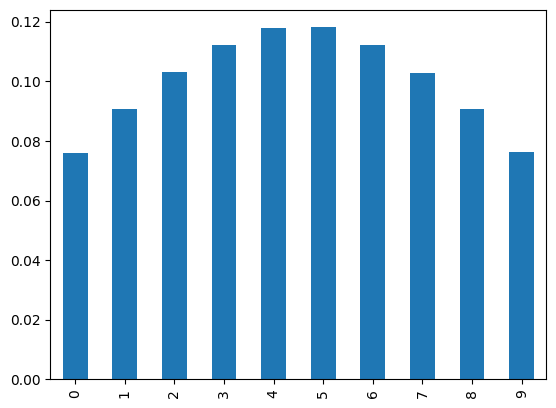

In [8]:
pd.Series(final_pdf).plot.bar()